<a href="https://colab.research.google.com/github/zee404-code/DartsTimeSeries/blob/main/darts09(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts

In [ ]:
from darts.datasets import AirPassengersDataset, AusBeerDataset, MonthlyMilkDataset, HeartRateDataset     
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality,remove_seasonality, remove_trend, stationarity_test_adf, stationarity_test_kpss, stationarity_tests
from darts.utils.model_selection import train_test_split
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.models import AutoARIMA, ARIMA, VARIMA, ExponentialSmoothing, TBATS, Theta, NBEATSModel, NHiTSModel
from darts.metrics import mape, coefficient_of_variation, dtw_metric, mae, marre, mase, mse, ope, r2_score, rho_risk, rmse, rmsle, smape
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data1 = AirPassengersDataset().load()
train1, test1 = train_test_split(data1, test_size=0.25, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)

data2 = AusBeerDataset().load()
train2, test2 = train_test_split(data2, test_size=0.25, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)

data3 = MonthlyMilkDataset().load()
train3, test3 = train_test_split(data3, test_size=0.25, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)

data4 = HeartRateDataset().load()
train4, test4 = train_test_split(data4, test_size=0.25, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)

In [ ]:
def visuals(train, test, model, length):
  model.fit(train)
  pred = model.predict(length)
  train.plot(label = 'training')
  test.plot(label = 'testing')
  pred.plot(label = 'prediction')

In [ ]:
def seasonality1(data):
  for m in range(2, 25):
    is_seasonal, period = check_seasonality(data, m=m, alpha=0.05)
    #print('running {}'.format(m))
    if is_seasonal:
       return period

In [ ]:
def seasonality2(data):
  for m in range(2, 25):
    is_seasonal, period = check_seasonality(data, m=m, alpha=0.05)
    #print('running {}'.format(m))
    if is_seasonal:
       return True

In [ ]:
def trend(data):
  check = stationarity_tests(data, 0.05, 0.05)
  return check

In [ ]:
#@title Default title text
length = 36 #@param {type:"integer"}
def removeStat(data, train, test):
  if (not stationarity_tests(data, 0.05, 0.05)) and seasonality2(data): #data does have trend and seasonality
    dataT, dataS = extract_trend_and_seasonality(data, freq=seasonality1(data), model=ModelMode.MULTIPLICATIVE, method='naive')
    #either data has trend, seasonality or both
    if (not stationarity_tests(dataT, 0.05, 0.05)) and (seasonality2(dataS)): #both
      dataF = remove_seasonality(data, freq=None, model=SeasonalityMode.ADDITIVE, method='STL')
      dataF = remove_trend(data, model=ModelMode.MULTIPLICATIVE, method='naive')
    elif not stationarity_tests(dataT, 0.05, 0.05): #only trend
      dataF = remove_trend(data, model=ModelMode.MULTIPLICATIVE, method='naive')
    else: #only seasonality
      dataF = remove_seasonality(data, freq=None, model=SeasonalityMode.MULTIPLICATIVE, method='naive')
  else: #data has no trend or seasonality
    dataF = data

  if dataF.is_univariate:
    model = ARIMA()
    #print(p, d, q)
  else:
    model = VARIMA()
  model.fit(train)
  
  predF = model.predict(length)
  #vis(test, train, predF)

  return dataF

In [ ]:
#removeStat(data2, train2, test2)

In [ ]:
def removeStat2(data, train, test):
  if (not stationarity_tests(data, 0.05, 0.05)) and seasonality2(data): #data does have trend and seasonality
    dataT, dataS = extract_trend_and_seasonality(data, freq=seasonality1(data), model=ModelMode.MULTIPLICATIVE, method='naive')
    #either data has trend, seasonality or both
    if (not stationarity_tests(dataT, 0.05, 0.05)) and (seasonality2(dataS)): #both
      dataF = remove_seasonality(data, freq=None, model=SeasonalityMode.ADDITIVE, method='STL')
      dataF = remove_trend(data, model=ModelMode.MULTIPLICATIVE, method='naive')
    elif not stationarity_tests(dataT, 0.05, 0.05): #only trend
      dataF = remove_trend(data, model=ModelMode.MULTIPLICATIVE, method='naive')
    else: #only seasonality
      dataF = remove_seasonality(data, freq=None, model=SeasonalityMode.MULTIPLICATIVE, method='naive')
  else: #data has no trend or seasonality
    dataF = data

  if dataF.is_univariate:
    model = ARIMA()
  else:
    model = VARIMA()
  model.fit(train)
  predF = model.predict(len(test))
  #vis(test, train, predF)

  return model

In [ ]:
#@title Default title text

def eval_model(model,n, data, train, test):
    
    #c = trend(removeStat(data, train,test))
    #print(c)
    print(seasonality1(removeStat(data, train, test)))
    model.fit(train)
    forecast = model.predict(n)
    dataF = removeStat(data, train, test)
    trainF , valF = dataF.split_before(0.75) 
    model.fit(trainF)
    forecastF = model.predict(n)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(test, forecast)))  # Mean Absolute Percentage Error (MAPE)
    print("model {} obtains MAPE ZW : {:.2f}%".format(model, mape(valF, forecast)))
    print("model {} obtains MSE: {:.2f}%".format(model, mse(test, forecast)))  # Mean Absolute Percentage Error (MAPE)
    print("model {} obtains MSE ZW: {:.2f}%".format(model, mse(valF, forecast)))
    print("model {} obtains MAE: {:.2f}%".format(model, mae(test, forecast)))  # Mean Absolute Percentage Error (MAPE)
    print("model {} obtains MAE ZW: {:.2f}%".format(model, mae(valF, forecast)))
    print("model {} obtains OPE: {:.2f}%".format(model, ope(test, forecast)))  # Mean Absolute Percentage Error (MAPE)
    print("model {} obtains OPE ZW: {:.2f}%".format(model, ope(valF, forecast)))
    print("model {} obtains RMSE: {:.2f}%".format(model, rmse(test, forecast)))  # Mean Absolute Percentage Error (MAPE)
    print("model {} obtains RMSE ZW: {:.2f}%".format(model, rmse(valF, forecastF)))
    print("model {} obtains RMSLE: {:.2f}%".format(model, rmsle(test, forecast)))
    print("model {} obtains RMSLE ZW: {:.2f}%".format(model, rmsle(valF, forecastF)))
    print("model {} obtains SMAPE: {:.2f}%".format(model, smape(test, forecast)))
    print("model {} obtains SMAPE ZW: {:.2f}%".format(model, smape(valF, forecastF)))
    trainF.plot(label = 'training')
    valF.plot(label = 'testing')
    forecastF.plot(label = 'prediction')
    
    #print("model {} obtains Rho Risk: {:.2f}%".format(model, rho_risk(val, forecast)))  # Mean Absolute Percentage Error (MAPE)


n = 60 #@param {type:"integer"}

#eval_model(ExponentialSmoothing(),n, data1, train1, test1)
#eval_model(TBATS(),n, data1, train1, test1)
#eval_model(AutoARIMA(),n, data1, train1, test1)
#eval_model(ARIMA(),n, data1, train1, test1)
#eval_model(Theta(),n, data1, train1, test1)

In [ ]:
#@title Test values for ARIMA() - Dataset 1 (Air Passengers) { run: "auto", vertical-output: true }
p = 12 #@param {type:"integer"}
d = 1 #@param {type:"integer"}
q = 0 #@param {type:"integer"}
length = 36 #@param {type:"integer"}
P = 0 #@param {type:"integer"}
D = 0 #@param {type:"integer"}
Q = 0 #@param {type:"integer"}
s = 0 #@param {type:"integer"}
trend = None #@param ["None"] {type:"raw", allow-input: true}
#Parameter controlling the deterministic trend. ‘n’ indicates no trend, ‘c’ a constant term, ‘t’ linear trend in time, and ‘ct’ includes both. Default is ‘c’ for models without integration, and no trend for models with integration.

#for trend and encoders select None from dropdown, else type input
encoders = None #@param ["None"] {type:"raw", allow-input: true}
random = 0 #@param {type:"integer"}

eval_model(ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders),n, data1, train1, test1)

In [ ]:
print('Air Passeneger Dataset Visualization - pre stationarity tests')
visuals(train1, test1, ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders), length)

4
model ARIMA(12, 1, 0) obtains MAPE: 3.66%
model ARIMA(12, 1, 0) obtains MAPE ZW : 44416.84%
model ARIMA(12, 1, 0) obtains MSE: 384.31%
model ARIMA(12, 1, 0) obtains MSE ZW: 199925.78%
model ARIMA(12, 1, 0) obtains MAE: 15.70%
model ARIMA(12, 1, 0) obtains MAE ZW: 444.88%
model ARIMA(12, 1, 0) obtains OPE: 3.19%
model ARIMA(12, 1, 0) obtains OPE ZW: 44421.98%
model ARIMA(12, 1, 0) obtains RMSE: 19.60%
model ARIMA(12, 1, 0) obtains RMSE ZW: 0.03%
model ARIMA(12, 1, 0) obtains RMSLE: 0.04%
model ARIMA(12, 1, 0) obtains RMSLE ZW: 0.02%
model ARIMA(12, 1, 0) obtains SMAPE: 3.57%
model ARIMA(12, 1, 0) obtains SMAPE ZW: 2.65%


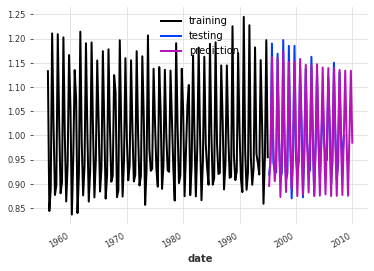

In [ ]:
#@title Test values for ARIMA() - Dataset 2 (Aus Beer) { run: "auto", vertical-output: true }
p = 12 #@param {type:"integer"}
d = 1 #@param {type:"integer"}
q = 0 #@param {type:"integer"}
length = 36 #@param {type:"integer"}
P = 0 #@param {type:"integer"}
D = 0 #@param {type:"integer"}
Q = 0 #@param {type:"integer"}
s = 0 #@param {type:"integer"}
trend = None #@param ["None"] {type:"raw", allow-input: true}
encoders = None #@param ["None"] {type:"raw", allow-input: true}
random = 0 #@param {type:"integer"}


eval_model(ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders),n, data2, train2, test2)

In [ ]:
print('Aus Beer Dataset Visualization - pre stationarity tests')
visuals(train2, test2, ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders), length)

In [ ]:
#@title Test values for ARIMA() - Dataset 3 (Monthly Milk) { run: "auto", vertical-output: true }
p = 12 #@param {type:"integer"}
d = 1 #@param {type:"integer"}
q = 0 #@param {type:"integer"}
length = 36 #@param {type:"integer"}
P = 0 #@param {type:"integer"}
D = 0 #@param {type:"integer"}
Q = 0 #@param {type:"integer"}
s = 0 #@param {type:"integer"}
trend = None #@param ["None"] {type:"raw", allow-input: true}
#Parameter controlling the deterministic trend. ‘n’ indicates no trend, ‘c’ a constant term, ‘t’ linear trend in time, and ‘ct’ includes both. Default is ‘c’ for models without integration, and no trend for models with integration.

#for trend and encoders select None from dropdown, else type input
encoders = None #@param ["None"] {type:"raw", allow-input: true}
random = 0 #@param {type:"integer"}

eval_model(ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders),n, data3, train3, test3)

In [ ]:
print('Monthly Milk Dataset Visualization - pre stationarity tests')
visuals(train3, test3, ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders), length)

In [ ]:
#@title Test values for ARIMA() - Dataset 4 (Heart Rate) { run: "auto", vertical-output: true }
p = 12 #@param {type:"integer"}
d = 1 #@param {type:"integer"}
q = 0 #@param {type:"integer"}
length = 36 #@param {type:"integer"}
P = 0 #@param {type:"integer"}
D = 0 #@param {type:"integer"}
Q = 0 #@param {type:"integer"}
s = 0 #@param {type:"integer"}
trend = None #@param ["None"] {type:"raw", allow-input: true}
#Parameter controlling the deterministic trend. ‘n’ indicates no trend, ‘c’ a constant term, ‘t’ linear trend in time, and ‘ct’ includes both. Default is ‘c’ for models without integration, and no trend for models with integration.

#for trend and encoders select None from dropdown, else type input
encoders = None #@param ["None"] {type:"raw", allow-input: true}
random = 0 #@param {type:"integer"}


eval_model(ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders),n, data4, train4, test4)

In [ ]:
print('Heart Rate Dataset Visualization - pre stationarity tests')
visuals(train4, test4, ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, s), trend=trend, random_state=random, add_encoders=encoders), length)

In [ ]:
#@title Set Values for AutoARIMA() for Dataset 1 (Air Passenger)
start_p = 2 #@param {type:"integer"}
d = None #@param {type:"raw"}
start_q = 2 #@param {type:"integer"}
max_p = 5 #@param {type:"integer"}
max_d = 2 #@param {type:"integer"}
max_q = 5 #@param {type:"integer"}
start_P = 1 #@param {type:"integer"}
D = None #@param {type:"raw"}
start_Q = 1 #@param {type:"integer"}
max_P = 1 #@param {type:"integer"}
max_D = 1 #@param {type:"integer"}
max_Q = 2 #@param {type:"integer"}
max_order = 5 #@param {type:"integer"}
m = 1 #@param {type:"integer"}
seasonal = True #@param {type:"boolean"}
stationary = False #@param {type:"boolean"}
information_criterion = "aic" #@param ["aic", "aicc", "hqic", "oob"]
alpha = 0.05 #@param {type:"number"}
test = 'kpss' #@param {type:"raw"}
seasonal_test = 'ocsb' #@param {type:"raw"}
stepwise = True #@param {type:"boolean"}
n_jobs = 1 #@param {type:"integer"}
start_params = None #@param {type:"raw"}
trend = None #@param {type:"raw"}
method = 'lbfgs' #@param ["'newton'", "'nm'", "'bfgs'", "'lbfgs'", "'powell'", "'cg'", "'ncg'", "\u2018basinhopping\u2019"] {type:"raw", allow-input: true}
maxiter = 50 #@param {type:"integer"}
offset_test_args = None #@param {type:"raw"}
seasonal_test_args = None #@param {type:"raw"}
suppress_warnings = True #@param {type:"boolean"}
error_action = 'trace' #@param ["'warn'", "'raise'", "'ignore'", "'trace'"] {type:"raw", allow-input: true}
trace = False #@param {type:"boolean"}
random = False #@param {type:"boolean"}
random_state = None #@param {type:"raw"}
n_fits = 10 #@param {type:"integer"}
out_of_sample_size = 0 #@param {type:"integer"}
scoring = 'mse' #@param {type:"raw"}
scoring_args = None #@param {type:"raw"}
with_intercept = 'auto' #@param {type:"raw"}


eval_model(AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept),n, data1, train1, test1)

In [ ]:
print('Air Passeneger Dataset Visualization - pre stationarity tests')
visuals(train1, test1, AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept), length)

In [ ]:
#@title Set Values for AutoARIMA() for Dataset 2 (Aus Beer)
start_p = 2 #@param {type:"integer"}
d = None #@param {type:"raw"}
start_q = 2 #@param {type:"integer"}
max_p = 5 #@param {type:"integer"}
max_d = 2 #@param {type:"integer"}
max_q = 5 #@param {type:"integer"}
start_P = 1 #@param {type:"integer"}
D = None #@param {type:"raw"}
start_Q = 1 #@param {type:"integer"}
max_P = 2 #@param {type:"integer"}
max_D = 1 #@param {type:"integer"}
max_Q = 2 #@param {type:"integer"}
max_order = 5 #@param {type:"integer"}
m = 1 #@param {type:"integer"}
seasonal = True #@param {type:"boolean"}
stationary = False #@param {type:"boolean"}
information_criterion = "aic" #@param ["aic", "aicc", "hqic", "oob"]
alpha = 0.05 #@param {type:"number"}
test = 'kpss' #@param {type:"raw"}
seasonal_test = 'ocsb' #@param {type:"raw"}
stepwise = True #@param {type:"boolean"}
n_jobs = 1 #@param {type:"integer"}
start_params = None #@param {type:"raw"}
trend = None #@param {type:"raw"}
method = 'lbfgs' #@param ["'newton'", "'nm'", "'bfgs'", "'lbfgs'", "'powell'", "'cg'", "'ncg'", "\u2018basinhopping\u2019"] {type:"raw", allow-input: true}
maxiter = 50 #@param {type:"integer"}
offset_test_args = None #@param {type:"raw"}
seasonal_test_args = None #@param {type:"raw"}
suppress_warnings = True #@param {type:"boolean"}
error_action = 'trace' #@param ["'warn'", "'raise'", "'ignore'", "'trace'"] {type:"raw", allow-input: true}
trace = False #@param {type:"boolean"}
random = False #@param {type:"boolean"}
random_state = None #@param {type:"raw"}
n_fits = 10 #@param {type:"integer"}
out_of_sample_size = 0 #@param {type:"integer"}
scoring = 'mse' #@param {type:"raw"}
scoring_args = None #@param {type:"raw"}
with_intercept = 'auto' #@param {type:"raw"}




eval_model(AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept),n, data2, train2, test2)

In [ ]:
print('Aus Beer Dataset Visualization - pre stationarity tests')
visuals(train2, test2, AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept), length)

In [ ]:
#@title Set Values for AutoARIMA() for Dataset 3 (Monthly Milk)
start_p = 2 #@param {type:"integer"}
d = None #@param {type:"raw"}
start_q = 2 #@param {type:"integer"}
max_p = 5 #@param {type:"integer"}
max_d = 2 #@param {type:"integer"}
max_q = 5 #@param {type:"integer"}
start_P = 1 #@param {type:"integer"}
D = None #@param {type:"raw"}
start_Q = 1 #@param {type:"integer"}
max_P = 2 #@param {type:"integer"}
max_D = 1 #@param {type:"integer"}
max_Q = 2 #@param {type:"integer"}
max_order = 5 #@param {type:"integer"}
m = 1 #@param {type:"integer"}
seasonal = True #@param {type:"boolean"}
stationary = False #@param {type:"boolean"}
information_criterion = "aic" #@param ["aic", "aicc", "hqic", "oob"]
alpha = 0.05 #@param {type:"number"}
test = 'kpss' #@param {type:"raw"}
seasonal_test = 'ocsb' #@param {type:"raw"}
stepwise = True #@param {type:"boolean"}
n_jobs = 1 #@param {type:"integer"}
start_params = None #@param {type:"raw"}
trend = None #@param {type:"raw"}
method = 'lbfgs' #@param ["'newton'", "'nm'", "'bfgs'", "'lbfgs'", "'powell'", "'cg'", "'ncg'", "\u2018basinhopping\u2019"] {type:"raw", allow-input: true}
maxiter = 50 #@param {type:"integer"}
offset_test_args = None #@param {type:"raw"}
seasonal_test_args = None #@param {type:"raw"}
suppress_warnings = True #@param {type:"boolean"}
error_action = 'trace' #@param ["'warn'", "'raise'", "'ignore'", "'trace'"] {type:"raw", allow-input: true}
trace = False #@param {type:"boolean"}
random = False #@param {type:"boolean"}
random_state = None #@param {type:"raw"}
n_fits = 10 #@param {type:"integer"}
out_of_sample_size = 0 #@param {type:"integer"}
scoring = 'mse' #@param {type:"raw"}
scoring_args = None #@param {type:"raw"}
with_intercept = 'auto' #@param {type:"raw"}




eval_model(AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept),n, data3, train3, test3)

In [ ]:
print('Monthly Milk Dataset Visualization - pre stationarity tests')
visuals(train3, test3, AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept), length)

In [ ]:
#@title Set Values for AutoARIMA() for Dataset 4 (Heart Rate)
start_p = 2 #@param {type:"integer"}
d = None #@param {type:"raw"}
start_q = 2 #@param {type:"integer"}
max_p = 5 #@param {type:"integer"}
max_d = 2 #@param {type:"integer"}
max_q = 5 #@param {type:"integer"}
start_P = 1 #@param {type:"integer"}
D = None #@param {type:"raw"}
start_Q = 1 #@param {type:"integer"}
max_P = 2 #@param {type:"integer"}
max_D = 1 #@param {type:"integer"}
max_Q = 2 #@param {type:"integer"}
max_order = 5 #@param {type:"integer"}
m = 1 #@param {type:"integer"}
seasonal = True #@param {type:"boolean"}
stationary = False #@param {type:"boolean"}
information_criterion = "aic" #@param ["aic", "aicc", "hqic", "oob"]
alpha = 0.05 #@param {type:"number"}
test = 'kpss' #@param {type:"raw"}
seasonal_test = 'ocsb' #@param {type:"raw"}
stepwise = True #@param {type:"boolean"}
n_jobs = 1 #@param {type:"integer"}
start_params = None #@param {type:"raw"}
trend = None #@param {type:"raw"}
method = 'lbfgs' #@param ["'newton'", "'nm'", "'bfgs'", "'lbfgs'", "'powell'", "'cg'", "'ncg'", "\u2018basinhopping\u2019"] {type:"raw", allow-input: true}
maxiter = 50 #@param {type:"integer"}
offset_test_args = None #@param {type:"raw"}
seasonal_test_args = None #@param {type:"raw"}
suppress_warnings = True #@param {type:"boolean"}
error_action = 'trace' #@param ["'warn'", "'raise'", "'ignore'", "'trace'"] {type:"raw", allow-input: true}
trace = False #@param {type:"boolean"}
random = False #@param {type:"boolean"}
random_state = None #@param {type:"raw"}
n_fits = 10 #@param {type:"integer"}
out_of_sample_size = 0 #@param {type:"integer"}
scoring = 'mse' #@param {type:"raw"}
scoring_args = None #@param {type:"raw"}
with_intercept = 'auto' #@param {type:"raw"}




eval_model(AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept),n, data4, train4, test4)

In [ ]:
print('Heart Rate Dataset Visualization - pre stationarity tests')
visuals(train4, test4, AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d, max_q=max_q, start_P=start_P, D=D, start_Q=start_Q, max_P=max_P, max_D=max_D, max_Q=max_Q, max_order=max_order, m=m, seasonal=seasonal, stationary=stationary, information_criterion=information_criterion, alpha=alpha, test=test, seasonal_test=seasonal_test, stepwise=stepwise, n_jobs=n_jobs, start_params=start_params, trend=trend, method=method, maxiter=maxiter, offset_test_args=offset_test_args, seasonal_test_args=seasonal_test_args, suppress_warnings=suppress_warnings, error_action=error_action, trace=trace, random=random, random_state=random_state, n_fits=n_fits, out_of_sample_size=out_of_sample_size, scoring=scoring, scoring_args=scoring_args, with_intercept=with_intercept), length)

In [ ]:
#@title Test Values for N-BEATS - Dataset 1 (Air Passenger)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True #@param {type:"boolean"}
num_stacks = 30 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 4 #@param {type:"integer"}
layer_widths = 256 #@param {type:"raw"}
expansion_coefficient_dim = 5 #@param {type:"integer"}
trend_polynomial_degree = 2 #@param {type:"integer"}
dropout = 0.0 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}


eval_model( NBEATSModel(input_chunk_length = input_chunk_length, output_chunk_length = output_chunk_length, generic_architecture=generic_architecture, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, expansion_coefficient_dim=expansion_coefficient_dim, trend_polynomial_degree=trend_polynomial_degree, dropout=dropout, activation=activation),n, data1, train1, test1)

In [ ]:
print('Air Passeneger Dataset Visualization - pre stationarity tests')
visuals(train1, test1, NBEATSModel(input_chunk_length = input_chunk_length, output_chunk_length = output_chunk_length, generic_architecture=generic_architecture, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, expansion_coefficient_dim=expansion_coefficient_dim, trend_polynomial_degree=trend_polynomial_degree, dropout=dropout, activation=activation), length)

In [ ]:
#@title Test Values for N-BEATS - Dataset 2 (Aus  Beer)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True #@param {type:"boolean"}
num_stacks = 30 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 4 #@param {type:"integer"}
layer_widths = 256 #@param {type:"raw"}
expansion_coefficient_dim = 5 #@param {type:"integer"}
trend_polynomial_degree = 2 #@param {type:"integer"}
dropout = 0.0 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}


eval_model( NBEATSModel(input_chunk_length = input_chunk_length, output_chunk_length = output_chunk_length, generic_architecture=generic_architecture, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, expansion_coefficient_dim=expansion_coefficient_dim, trend_polynomial_degree=trend_polynomial_degree, dropout=dropout, activation=activation),n, data2, train2, test2)

In [ ]:
#@title Test Values for N-BEATS - Dataset 3 (Monthly Milk)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True #@param {type:"boolean"}
num_stacks = 30 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 4 #@param {type:"integer"}
layer_widths = 256 #@param {type:"raw"}
expansion_coefficient_dim = 5 #@param {type:"integer"}
trend_polynomial_degree = 2 #@param {type:"integer"}
dropout = 0.0 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}


eval_model( NBEATSModel(input_chunk_length = input_chunk_length, output_chunk_length = output_chunk_length, generic_architecture=generic_architecture, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, expansion_coefficient_dim=expansion_coefficient_dim, trend_polynomial_degree=trend_polynomial_degree, dropout=dropout, activation=activation),n, data3, train3, test3)

In [ ]:
#@title Test Values for N-BEATS - Dataset 4 (Heart Rate)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True #@param {type:"boolean"}
num_stacks = 30 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 4 #@param {type:"integer"}
layer_widths = 256 #@param {type:"raw"}
expansion_coefficient_dim = 5 #@param {type:"integer"}
trend_polynomial_degree = 2 #@param {type:"integer"}
dropout = 0.0 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}


eval_model( NBEATSModel(input_chunk_length = input_chunk_length, output_chunk_length = output_chunk_length, generic_architecture=generic_architecture, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, expansion_coefficient_dim=expansion_coefficient_dim, trend_polynomial_degree=trend_polynomial_degree, dropout=dropout, activation=activation),n, data4, train4, test4)

In [ ]:
#@title Test Values for N-HITS - Dataset 1 (Air Passenger)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True
num_stacks = 3 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 2 #@param {type:"integer"}
layer_widths = 512 #@param {type:"raw"}
expansion_coefficient_dim = 5
trend_polynomial_degree = 2
dropout = 0.1 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}
pooling_kernel_sizes = None #@param {type:"raw"}
MaxPool1d = True #@param {type:"boolean"}
n_freq_downsample = None #@param {type:"raw"}


eval_model( NHiTSModel(input_chunk_length, output_chunk_length, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, pooling_kernel_sizes=pooling_kernel_sizes, n_freq_downsample=n_freq_downsample, dropout=dropout, activation=activation, MaxPool1d=MaxPool1d),n, data1, train1, test1)

In [ ]:
#@title Test Values for N-HITS - Dataset 2 (Aus Beer)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True
num_stacks = 3 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 2 #@param {type:"integer"}
layer_widths = 512 #@param {type:"raw"}
expansion_coefficient_dim = 5
trend_polynomial_degree = 2
dropout = 0.1 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}
pooling_kernel_sizes = None #@param {type:"raw"}
MaxPool1d = True #@param {type:"boolean"}
n_freq_downsample = None #@param {type:"raw"}


eval_model( NHiTSModel(input_chunk_length, output_chunk_length, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, pooling_kernel_sizes=pooling_kernel_sizes, n_freq_downsample=n_freq_downsample, dropout=dropout, activation=activation, MaxPool1d=MaxPool1d),n, data2, train2, test2)

In [ ]:
#@title Test Values for N-HITS - Dataset 3 (Monthly Milk)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True
num_stacks = 3 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 2 #@param {type:"integer"}
layer_widths = 512 #@param {type:"raw"}
expansion_coefficient_dim = 5
trend_polynomial_degree = 2
dropout = 0.1 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}
pooling_kernel_sizes = None #@param {type:"raw"}
MaxPool1d = True #@param {type:"boolean"}
n_freq_downsample = None #@param {type:"raw"}


eval_model( NHiTSModel(input_chunk_length, output_chunk_length, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, pooling_kernel_sizes=pooling_kernel_sizes, n_freq_downsample=n_freq_downsample, dropout=dropout, activation=activation, MaxPool1d=MaxPool1d),n, data3, train3, test3)

In [ ]:
#@title Test Values for N-HITS - Dataset 4 (Heart Rate)
input_chunk_length = 0 #@param {type:"integer"}
output_chunk_length = 0 #@param {type:"integer"}
generic_architecture = True
num_stacks = 3 #@param {type:"integer"}
num_blocks = 1 #@param {type:"integer"}
num_layers = 2 #@param {type:"integer"}
layer_widths = 512 #@param {type:"raw"}
expansion_coefficient_dim = 5
trend_polynomial_degree = 2
dropout = 0.1 #@param {type:"number"}
activation = 'ReLU' #@param ["'ReLU'", "'RReLU'", "'PReLU'", "'Softplus'", "'Tanh'", "'SELU'", "'LeakyReLU'", "'Sigmoid'"] {type:"raw", allow-input: true}
pooling_kernel_sizes = None #@param {type:"raw"}
MaxPool1d = True #@param {type:"boolean"}
n_freq_downsample = None #@param {type:"raw"}


eval_model( NHiTSModel(input_chunk_length, output_chunk_length, num_stacks=num_stacks, num_blocks=num_blocks, num_layers=num_layers, layer_widths=layer_widths, pooling_kernel_sizes=pooling_kernel_sizes, n_freq_downsample=n_freq_downsample, dropout=dropout, activation=activation, MaxPool1d=MaxPool1d),n, data4, train4, test4)

In [ ]:
#@title Test VAlues for VARIMA() Dataset 1 (Air Passenger)
from darts.datasets import ElectricityDataset
series = ElectricityDataset().load()
train, test = series.split_before(0.66)
from darts.dataprocessing.transformers import Scaler
multi_serie_elec = ElectricityDataset().load()
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

scaler_dataset = Scaler()

def fit_and_pred(model, training, validation):
  model.fit(training)
  forecast = model.predict(len(validation))
  return forecast

training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)

p = 1 #@param {type:"integer"}
d = 0 #@param {type:"integer"}
q = 0 #@param {type:"integer"}
trend = None #@param {type:"raw"}
encoders = None #@param {type:"raw"}

#eval_model(VARIMA(p=p, d=d, q=q, trend = trend), n, series, training_scaled, validation_scaled)
